## Introduction

### What causes risks for cycling?

Perception of risk impedes people from cycling. This project's goal is to build an AI model to estimate a
score of perceived road safety based on Google Street View images.

According to the literature, to maintain the highest level of safety on the roads, cyclists should avoid hazards or situations to avoid that may cause them to fall, like toys, pebbles, potholes, grates, train tracks.(in: https://www.nhtsa.gov/road-safety/bicycle-safety)

Infrastructure quality and layout play a role in the occurrence and outcome of bicycle crashes. Road surface that suffers from pits, trenches, drain covers, tree root encroachments, etc., is often the reason for a single-bicycle crash (SWOV 2017). Visibility of obstacles, the road course and the width of bicycle paths and lanes also add to the crash risk. 

### What did we do here?

Starting from a very open problem - where all that is asked is to predict road street quality - we tried to create a set of models that would give us some objective measure of risk level.

TBD



## Development

In [10]:
# !pip install reverse_geocoder
# !pip3 install tensorflow
# !pip install opencv-contrib-python
# !pip install cvlib
!pip install tensorflow==2.0.0

# Import packages

import pandas as pd
import numpy as np
import os
import re
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import pickle

#imports for deep learning
import tensorflow as tf
from tensorflow.keras import utils, callbacks, models, regularizers, Input, losses, metrics
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from keras_preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import GroupShuffleSplit
from PIL import Image


# Imports
import cv2
import matplotlib.pyplot as plt
import cvlib as cv
from cvlib.object_detection import draw_bbox

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached absl_py-0.12.0-py3-none-any.whl (129 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached wrapt-1.12.1.tar.gz (27 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached Markdown-3.3.4-py3-none-any.whl (97 kB)
  Using cached google_auth_oauthlib-0.4.4-py2.py3-none-any.whl (18 kB)
  Using cached google_auth-1.30.0-py2.py3-none-any.whl (146 kB)
  Using cached rsa-4.7.2-py3-none-any.whl (34 kB)
  Using cached cachetools-4.2.2-py3-none-any.whl (11 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Using cached oauthlib-3.1.0-py2.py3-none-any.whl (147 kB)
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7538 sha256=57a9923067a4cd016cdfd6d297bc153450af0f60

ModuleNotFoundError: No module named 'cv2'

In [9]:
annotations = pd.read_csv('annotations_final.csv')

In [25]:
annotations['image'] = annotations['image'].apply(lambda x: x.split('/')[-1])
annotations['image_group'] = annotations.image_name.str.extract(r"(image\d{1,})")

annotations['irrelevant_infer'] = (annotations['street_width']=='irrelevant_image') * 1

In [15]:
def get_mapping_name_coords(data_path):
    """
    This function uses the coordinates.txt files to map an image name to its coordinates, as a tuple.
    
    Input example: lat:38.76039827177381;lng-9.190202095966573

    Args:
        data_path (str): The path containing the coordinates cada.
        
    Returns:
        (pd.DataFrame): A Dataframe containing two columns: image name and corresponding coordinates.
    """
    coordinates_files = os.listdir(data_path)

    mapping_name_coords = []

    for file in coordinates_files:
        with open(data_path + file, 'r') as f:
            content = f.read()
            content_split = content.split(';')
            
            # Pre-process text to retain only latitude and longitude.
            lat = re.sub("[^0-9.-]", "", content_split[0])
            long = re.sub("[^0-9.-]", "", content_split[1])

            mapping_name_coords.append([file[:-4], (lat, long)])
    
    return pd.DataFrame(mapping_name_coords, columns=['name', 'coordinates'])

mapping_name_coords = get_mapping_name_coords('data/coordinates/')

Load cycling network

In [56]:
import requests
import numpy as np
import pandas as pd

url = "https://services.arcgis.com/1dSrzEWVQn5kHHyK/arcgis/rest/services/Ciclovias/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
ciclovias = requests.get(url).json()

ret = []
for row in ciclovias['features']:
    ret.append({
        'geometry': row['geometry']['paths'],
        'center_of_mass': np.mean(row['geometry']['paths'][0], axis=0),
        'tipologia': row['attributes']['TIPOLOGIA'],
        'DESIGNACAO': row['attributes']['DESIGNACAO']
    })
ciclovias_df = pd.DataFrame.from_dict(ret)
ciclovias_df['coordinates'] = ciclovias_df['center_of_mass'].apply(lambda x: (x[1], x[0]))
ciclovias_df['coordinates'] = ciclovias_df['coordinates'].astype(str)

In [57]:
from geopy.geocoders import Nominatim

def add_reverse_coords(df):
    locator = Nominatim(user_agent="google")

    reverse_coords = [
        locator.reverse(eval(x)).raw for x in list(df['coordinates'])
    ]
    df['freguesia'] = [x.get('address').get('suburb', "None") for x in reverse_coords]
    df['concelho'] = [x.get('address').get('county', "None") for x in reverse_coords]
    df['cidade'] = [x.get('address').get('city', "None") for x in reverse_coords]
    
    return df

ciclovias_df = add_reverse_coords(ciclovias_df)

In [48]:
load_from_cache = 1

if not load_from_cache:
    # This step is slow, should only run once
    mapping_name_coords = add_reverse_coords(mapping_name_coords)
    ciclovias_df = add_reverse_coords(ciclovias_df)
    ciclovias_df = ciclovias_df.drop_duplicates('DESIGNACAO').reset_index()
    ciclovias_df.to_csv('data/ciclovias_df.csv')
    mapping_name_coords.to_csv('data/mapping_name_coords.csv')
else:
    mapping_name_coords = pd.read_csv('data/mapping_name_coords.csv')
    ciclovias_df = pd.read_csv('data/ciclovias_df.csv')

In [49]:
mapping_name_coords.head(3)

Unnamed: 0     name                                  coordinates  \
0           0   image0     ('38.73277225961562', '-9.172048739336')   
1           1   image1  ('38.76039827177381', '-9.190202095966573')   
2           2  image10                 ('38.7439627', '-9.1136023')   

   freguesia concelho  cidade  
0  Campolide   Lisboa  Lisboa  
1    Carnide   Lisboa  Lisboa  
2    Marvila   Lisboa  Lisboa

### Represent Datapoints

Plot scatter map in Lisbon area

Plot as lines as ciclovias

### Labeled Classes

We labeled the following classes in order to objectively classify pavement quality:

- Irrelevant view: whenever the street is fully visible or the image is just pointing to a wall
- Street width: a single car could fit the street vs more than one car could fit there
- Pavement Type: parallel (paralelo), tar (alcatrão) or dirt (terra batida)
- Pavement quality: For tar streets, whether or not it had:
    - No visible damage
    - Some visible cracks
    - Both cracks and patches/holes
    
Rules for annotation and modeling:

- Whenever image is "irrelevant", dont label anything else
- Whenever type is different from "alcatrão", don't label street quality

In [11]:
annotations.head()

image   id        street_width  \
0  /data/upload/image26angle180.jpg  135    irrelevant_image   
1  /data/upload/image13angle180.jpg   66  double_car_or_more   
2    /data/upload/image50angle0.jpg  249    irrelevant_image   
3   /data/upload/image50angle90.jpg  250  double_car_or_more   
4  /data/upload/image50angle180.jpg  251    irrelevant_image   

                   annotator annotation_id pavement_type pavement_quality  \
0  paulomanuelmaia@gmail.com           135           NaN              NaN   
1  paulomanuelmaia@gmail.com            66      alcatrao              mid   
2  paulomanuelmaia@gmail.com           249           NaN              NaN   
3  paulomanuelmaia@gmail.com           250      alcatrao             high   
4  paulomanuelmaia@gmail.com           251           NaN              NaN   

            image_name image_group  
0  image26angle180.jpg     image26  
1  image13angle180.jpg     image13  
2    image50angle0.jpg     image50  
3   image50angle90.jpg     image50  
4  image50angle180.jpg     image50

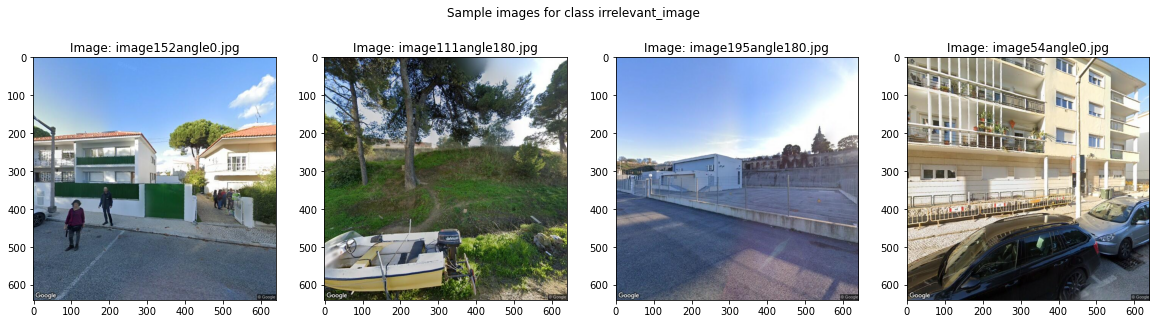

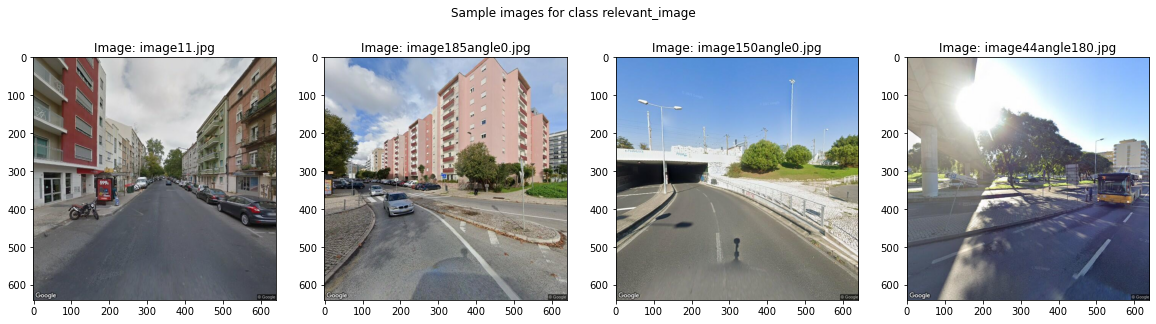

In [18]:
IMAGES_PATH = 'data/images/'
CLASS_NAME = 'irrelevant_image'

def make_plot(masked_df, CLASS_NAME, IMAGES_PATH):
    """
    This function takes a masked annotations dataframe (containing only the rows we want to consider)
        and plots 4 randomly selected images of that class.

    Args:
        masked_df (pd.DataFrame): Masked dataframe.
        CLASS_NAME (str): An indicator of the class name, for th etitle.
        IMAGES_PATH (str): The path containing the images.
    """
    images_name = list(masked_df.sample(5, replace=False)['image_name'])
    images = [plt.imread(IMAGES_PATH + x) for x in images_name]
    # Show subplots | shape: (1,3) 
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    for i, ax in enumerate(axs.flatten()):
        plt.sca(ax)
        plt.imshow(images[i])
        plt.title('Image: {}'.format(images_name[i]))

    plt.suptitle(f'Sample images for class {CLASS_NAME}')
    plt.show()
    
make_plot(annotations[annotations['street_width'] == 'irrelevant_image'], 'irrelevant_image', IMAGES_PATH)
make_plot(annotations[annotations['street_width'] != 'irrelevant_image'], 'relevant_image', IMAGES_PATH)

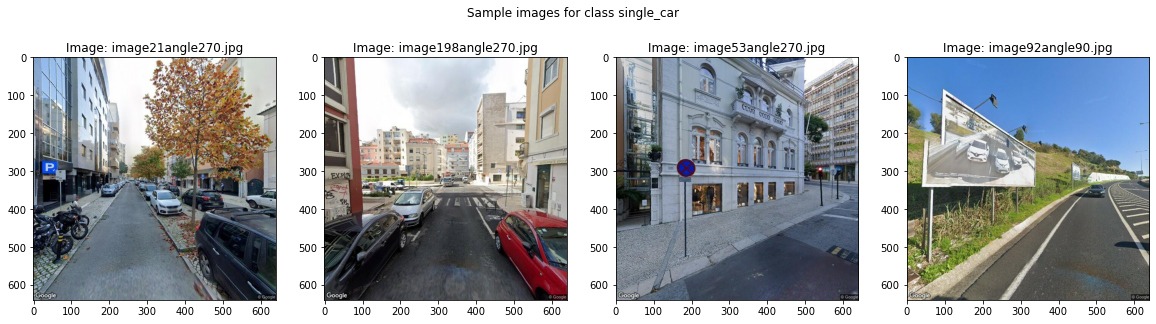

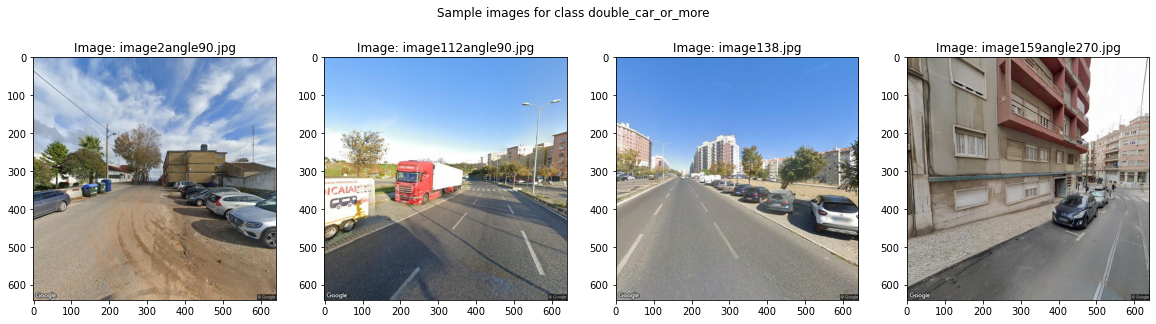

In [22]:
make_plot(annotations[annotations['street_width'] == 'single_car'], 'single_car', IMAGES_PATH)
make_plot(annotations[annotations['street_width'] == 'double_car_or_more'], 'double_car_or_more', IMAGES_PATH)

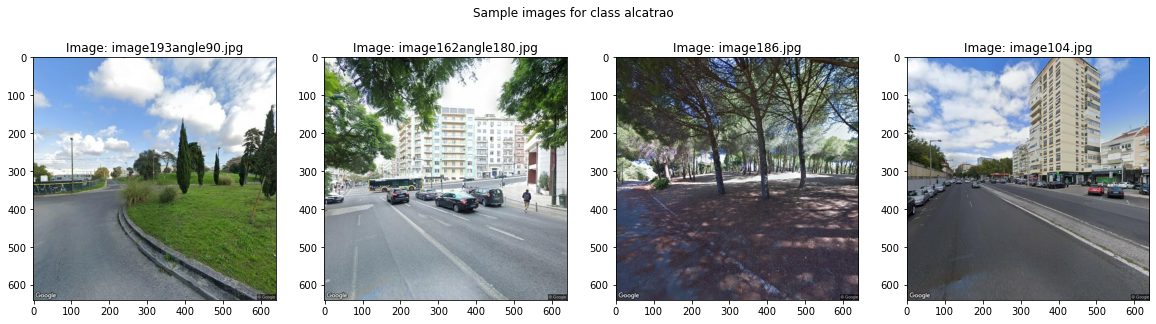

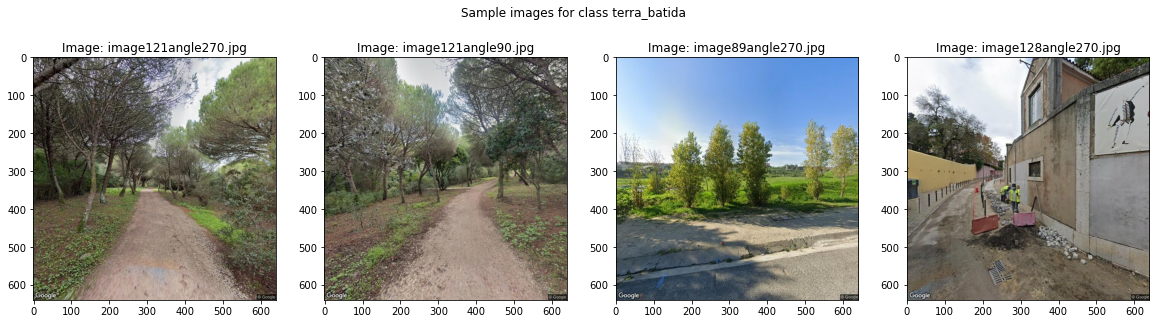

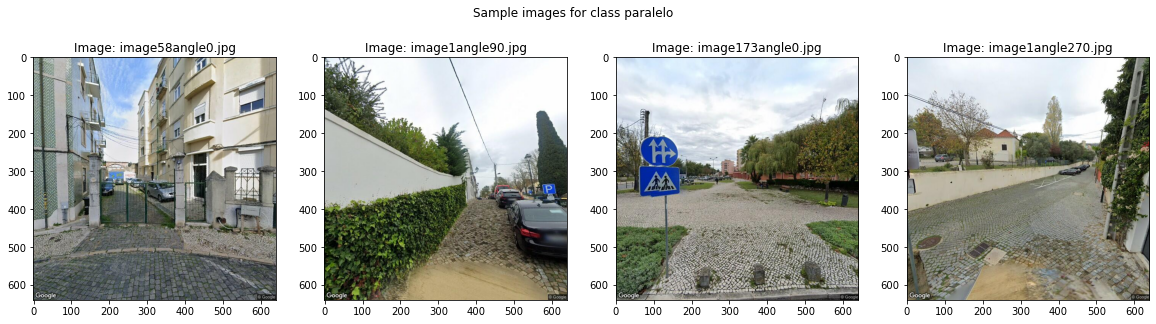

In [24]:
make_plot(annotations[annotations['pavement_type'] == 'alcatrao'], 'alcatrao', IMAGES_PATH)
make_plot(annotations[annotations['pavement_type'] == 'terra_batida'], 'terra_batida', IMAGES_PATH)
make_plot(annotations[annotations['pavement_type'] == 'paralelo'], 'paralelo', IMAGES_PATH)

### Deep Learning Models

##### Car Detection

The presence of detected cars/people in a certain region can be indicative of the risk level for cycling: regions with the presence of cars (either parked or driving) show that area has movement.

The absence does not indicate it doesn't - as the Street View images are taken at different times - but statistically, if a car appears there, it means there's more movement on average, compared to the areas without cars.

We used YOLO model to count the number of cars in all the dataset images. Below, just an example was shown, as this was pre-calculated separately. 

In [7]:
sample_images = [
    'code/car_counter_kerastf/dset_img_1.jpg',
    'code/car_counter_kerastf/dset_img_2.jpg',
    'code/car_counter_kerastf/dset_img_3.jpg',
    'code/car_counter_kerastf/dset_img_4.jpg'
]

def plot_detected_cars(sample_images):
    # Show subplots | shape: (1,3) 
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    for i, ax in enumerate(axs.flatten()):
        plt.sca(ax)
        im = cv2.imread(cv2.cvtColor(sample_images[i], cv2.COLOR_BGR2RGB))

        # Count cars
        bbox, label, conf = cv.detect_common_objects(im)
        output_image = draw_bbox(im, bbox, label, conf)
        plt.imshow(output_image)

plot_detected_cars(sample_images)

NameError: name 'plt' is not defined

In [5]:
import numpy as np
import os
import pandas as pd

car_counts = "car_count_results.npy"

# Open numpy
car_counts = np.load(file=car_counts, allow_pickle=True)

car_counts_df = pd.DataFrame(car_counts, columns = ['image_name','nr_cars'])

In [6]:
car_counts_df

image_name nr_cars
0                    image0.jpg       2
1              image0angle0.jpg       4
2            image0angle180.jpg       1
3            image0angle270.jpg       1
4             image0angle90.jpg       0
...                         ...     ...
9995  votingImage99angle270.jpg       9
9996   votingImage99angle90.jpg       5
9997   votingImage9angle180.jpg       0
9998   votingImage9angle270.jpg       0
9999    votingImage9angle90.jpg       0

[10000 rows x 2 columns]

Choose the model that you want to train: 'irrelevante_check', 'multitask' or 'quality'

In [ ]:
what_to_train='quality'

# hyperparameters of the model
EPOCHS = 100
batch_size=32
LR=0.0001

### Data Loaders

In [ ]:
df = annotations.copy()

# Change dataframe for every specific task
if what_to_train=='quality':
    df = df[df['pavement_quality'].notna()]

elif what_to_train=='multitask':
    df = df[df['pavement_type'].notna()]
    df['pavement_type'][df['pavement_type']=='alcatrao']=0
    df['pavement_type'][df['pavement_type']=='terra_batida']=1
    df['pavement_type'][df['pavement_type']=='paralelo']=2
    df['street_width'][df['street_width']=='single_car']=0
    df['street_width'][df['street_width']=='double_car_or_more']=1
    
#Train vs test division of dataframe by group of images 

df = df[df['image'].notna()]

#binary quality check
df['pavement_quality'][df['pavement_quality']=='mid']='low'
df['quality_check'] = (df['pavement_quality']=='high')*1

train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state =42).split(df, groups=df['image_group']))
train = df.iloc[train_inds]
test = df.iloc[test_inds]

#images generator for multitask 
def multitask_generator(data, batch_size=32):
        imagePath = "images/"
        # imagePath = "data/Competition/images/"

        swID = len(data.street_width.unique())
        ptID = len(data.pavement_type.unique())
        images, sws,pts = [], [], []
        while True:
            for i in range(0, data.shape[0]):
                r = data.iloc[i]
                name, sw, pt = r['image'], r['street_width'], r['pavement_type']
                im = Image.open(imagePath+name)
                im = im.resize((224, 224))
                im = np.array(im) / 255.0
                images.append(im)
                sws.append(tf.keras.utils.to_categorical(sw, swID))
                pts.append(tf.keras.utils.to_categorical(pt, ptID))
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(sws), np.array(pts)]
                    images, sws, pts = [], [], []


datagen=ImageDataGenerator(rescale=1./255.,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1)

test_datagen = ImageDataGenerator(rescale=1./255)


def train_generator(images="image", y_true="irrelevant_infer", class_type="raw"):
    train_gen=datagen.flow_from_dataframe(
    dataframe=train,
    directory="images/",
    x_col=images,
    y_col=y_true,
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode=class_type,
    target_size=(224,224))
    
    return train_gen

def test_generator(images="image", y_true="irrelevant_infer", class_type="raw", BS=32):
    test_gen=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory="images/",
    x_col=images,
    y_col=y_true,
    batch_size=BS,
    seed=42,
    shuffle=False,
    class_mode=class_type,
    target_size=(224,224))
    return test_gen

### Model

In [ ]:
def model(lr=0.0001, input_shape=(224, 224, 3), model_name = 'irrelevant_vs_relevant'):
    
    
    base_model=MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(200, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation="relu")(x)
    
    if model_name == 'irrelevant_vs_relevant':
        out = Dense(1, activation="sigmoid", name='irrelevant')(x)
        loss = losses.binary_crossentropy

    elif model_name == 'multitask':
        out_width = Dense(1, activation="sigmoid", name='number_cars')(x)
        out_pavement = Dense(3, activation="softmax", name='pavement')(x)
        loss = [losses.binary_crossentropy, losses.categorical_crossentropy]
        
        out = [out_width, out_pavement]
        
    elif model_name == 'quality':
        out = Dense(1, activation='sigmoid', name='quality')(x)
        loss = losses.binary_crossentropy
        
    model = Model(inputs = base_model.input, outputs = out)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer, loss, metrics=['accuracy'])

    return model

### Train 

In [ ]:
if what_to_train=='irrelevante_check':
    train_gen=train_generator()
    test_gen=test_generator()
    model=model(lr=LR)
    monitor_check='val_loss'


elif what_to_train=='multitask':
    train_gen  = multitask_generator(train, batch_size=batch_size)
    test_gen  = multitask_generator(test, batch_size=batch_size)
    model=model(lr=LR ,model_name = 'multitask')
    monitor_check='val_pavement_loss'
    
# elif what_to_train=='quality':
#     train_gen=train_generator(y_true="pavement_quality",class_type="categorical")
#     test_gen=test_generator(y_true="pavement_quality",class_type="categorical")
#     model=model(lr=LR, model_name ='quality')
#     monitor_check='val_loss'

elif what_to_train=='quality':
    train_gen=train_generator(y_true="quality_check")
    test_gen=test_generator(y_true="quality_check")
    model=model(lr=LR, model_name ='quality')
    monitor_check='val_loss'

#train cycle

STEP_SIZE_TRAIN=len(train)//batch_size
STEP_SIZE_VALID=len(test)//batch_size


checkpoint_filepath = what_to_train+'.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=monitor_check,
    mode='min',
    save_best_only=True,
    verbose=1)

history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    callbacks=[model_checkpoint_callback]
)

## Model Evaluation

In [ ]:
# Save 

### Model Inferencing on complete dataset

In [18]:
# Dictionary to map street width predictions into class names
street_width_class_names = {
    0:'single_car',
    1:'double_car_or_more'
}

# Dictionary to map pavement type predictions into class names
pavement_type_class_names = {
    0:'alcatrao',
    1:'terra_batida',
    2:'paralelo'
}


# Dictionary to map quality type predictions into class names
quality_class_names = {
    0:'low',
    1:'high'
}

# Dictionary to map pavement type names into risk scores 
pavement_type_risk_scores = {
    'alcatrao': 1,
    'terra_batida': 2,
    'paralelo': 3
}

# Dictionary to map pavement quality names into risck scores
pavement_quality_risk_scores = {
    'low': 0,
    'high': 1
}


# Get scores for all images
full_dataset = pd.read_csv("results/results_dataframe_final.csv")


# Open car predictions information
car_counts = np.load(file="car_count_results.npy", allow_pickle=True)
# print(car_counts.shape)

# Create dataframe
car_counts_df = pd.DataFrame(car_counts, columns = ['image','nr_cars'])
# car_counts_df.head()


# Join with full_dataset
full_dataset = full_dataset.merge(car_counts_df, how="left", on="image").reset_index()


# Rearrange some of the names
full_dataset.image = full_dataset.image.str.replace('votingImage', 'vimage')

# Get images by group
full_dataset['image_group'] = full_dataset['image'].str.extract(r"(v?image\d{1,})")
full_dataset.head()

# Sanity-check print; should output: (10000, 12)
# print(full_dataset.shape)

index               image  is_irrelevant_prob  is_irrelevant_class  \
0      0          image0.jpg            0.085232                    0   
1      1    image0angle0.jpg            0.272308                    0   
2      2  image0angle180.jpg            0.188764                    0   
3      3  image0angle270.jpg            0.174393                    0   
4      4   image0angle90.jpg            0.337263                    0   

   street_width_prob  street_width_class  pavement_type_prob_alcatrao  \
0           0.504905                   1                     0.999983   
1           0.505969                   1                     0.999923   
2           0.433664                   0                     0.997363   
3           0.332103                   0                     0.996514   
4           0.476578                   0                     0.997943   

   pavement_type_prob_terra_batida  pavement_type_prob_paralelo  \
0                         0.000002                     0.000015   
1                         0.000014                     0.000062   
2                         0.000860                     0.001777   
3                         0.001917                     0.001569   
4                         0.000248                     0.001809   

   pavement_type_class  quality_prob  quality_class nr_cars image_group  
0                    0      0.695535              1       2      image0  
1                    0      0.652902              1       4      image0  
2                    0      0.606895              1       1      image0  
3                    0      0.395713              0       1      image0  
4                    0      0.383391              0       0      image0

In [19]:
# Check if tha names we fixed above are correct
full_dataset.tail()

index                 image  is_irrelevant_prob  is_irrelevant_class  \
9995   9995  vimage99angle270.jpg            0.056106                    0   
9996   9996   vimage99angle90.jpg            0.087394                    0   
9997   9997   vimage9angle180.jpg            0.065303                    0   
9998   9998   vimage9angle270.jpg            0.058808                    0   
9999   9999    vimage9angle90.jpg            0.275563                    0   

      street_width_prob  street_width_class  pavement_type_prob_alcatrao  \
9995           0.496789                   0                     0.999286   
9996           0.526996                   1                     0.999989   
9997           0.330794                   0                     0.985109   
9998           0.483643                   0                     0.999365   
9999           0.410283                   0                     0.457765   

      pavement_type_prob_terra_batida  pavement_type_prob_paralelo  \
9995                         0.000055                     0.000659   
9996                         0.000002                     0.000009   
9997                         0.012677                     0.002213   
9998                         0.000111                     0.000524   
9999                         0.007005                     0.535230   

      pavement_type_class  quality_prob  quality_class nr_cars image_group  
9995                    0      0.627633              1       9    vimage99  
9996                    0      0.582326              1       5    vimage99  
9997                    0      0.529123              1       0     vimage9  
9998                    0      0.485573              0       0     vimage9  
9999                    2      0.486551              0       0     vimage9

In [20]:
# Map the number of cars to a new column called "has_cars"
# Which tells us if we have cars in that place
full_dataset["has_cars"] = full_dataset["nr_cars"] > 0
full_dataset["has_cars"] = full_dataset["has_cars"].astype(int)
full_dataset

index                 image  is_irrelevant_prob  is_irrelevant_class  \
0         0            image0.jpg            0.085232                    0   
1         1      image0angle0.jpg            0.272308                    0   
2         2    image0angle180.jpg            0.188764                    0   
3         3    image0angle270.jpg            0.174393                    0   
4         4     image0angle90.jpg            0.337263                    0   
...     ...                   ...                 ...                  ...   
9995   9995  vimage99angle270.jpg            0.056106                    0   
9996   9996   vimage99angle90.jpg            0.087394                    0   
9997   9997   vimage9angle180.jpg            0.065303                    0   
9998   9998   vimage9angle270.jpg            0.058808                    0   
9999   9999    vimage9angle90.jpg            0.275563                    0   

      street_width_prob  street_width_class  pavement_type_prob_alcatrao  \
0              0.504905                   1                     0.999983   
1              0.505969                   1                     0.999923   
2              0.433664                   0                     0.997363   
3              0.332103                   0                     0.996514   
4              0.476578                   0                     0.997943   
...                 ...                 ...                          ...   
9995           0.496789                   0                     0.999286   
9996           0.526996                   1                     0.999989   
9997           0.330794                   0                     0.985109   
9998           0.483643                   0                     0.999365   
9999           0.410283                   0                     0.457765   

      pavement_type_prob_terra_batida  pavement_type_prob_paralelo  \
0                            0.000002                     0.000015   
1                            0.000014                     0.000062   
2                            0.000860                     0.001777   
3                            0.001917                     0.001569   
4                            0.000248                     0.001809   
...                               ...                          ...   
9995                         0.000055                     0.000659   
9996                         0.000002                     0.000009   
9997                         0.012677                     0.002213   
9998                         0.000111                     0.000524   
9999                         0.007005                     0.535230   

      pavement_type_class  quality_prob  quality_class nr_cars image_group  \
0                       0      0.695535              1       2      image0   
1                       0      0.652902              1       4      image0   
2                       0      0.606895              1       1      image0   
3                       0      0.395713              0       1      image0   
4                       0      0.383391              0       0      image0   
...                   ...           ...            ...     ...         ...   
9995                    0      0.627633              1       9    vimage99   
9996                    0      0.582326              1       5    vimage99   
9997                    0      0.529123              1       0     vimage9   
9998                    0      0.485573              0       0     vimage9   
9999                    2      0.486551              0       0     vimage9   

      has_cars  
0            1  
1            1  
2            1  
3            1  
4            0  
...        ...  
9995         1  
9996         1  
9997         0  
9998         0  
9999         0  

[10000 rows x 15 columns]

In [21]:
# Map predicted street width classes into names
full_dataset['street_width'] = full_dataset['street_width_class'].map(street_width_class_names)

# Map predicted pavement type classes into names
full_dataset['pavement_type'] = full_dataset['pavement_type_class'].map(pavement_type_class_names)

# Map predicted quality classes into names
full_dataset['pavement_quality'] = full_dataset['quality_class'].map(quality_class_names)

# Get full dataset to some sanity check
full_dataset

index                 image  is_irrelevant_prob  is_irrelevant_class  \
0         0            image0.jpg            0.085232                    0   
1         1      image0angle0.jpg            0.272308                    0   
2         2    image0angle180.jpg            0.188764                    0   
3         3    image0angle270.jpg            0.174393                    0   
4         4     image0angle90.jpg            0.337263                    0   
...     ...                   ...                 ...                  ...   
9995   9995  vimage99angle270.jpg            0.056106                    0   
9996   9996   vimage99angle90.jpg            0.087394                    0   
9997   9997   vimage9angle180.jpg            0.065303                    0   
9998   9998   vimage9angle270.jpg            0.058808                    0   
9999   9999    vimage9angle90.jpg            0.275563                    0   

      street_width_prob  street_width_class  pavement_type_prob_alcatrao  \
0              0.504905                   1                     0.999983   
1              0.505969                   1                     0.999923   
2              0.433664                   0                     0.997363   
3              0.332103                   0                     0.996514   
4              0.476578                   0                     0.997943   
...                 ...                 ...                          ...   
9995           0.496789                   0                     0.999286   
9996           0.526996                   1                     0.999989   
9997           0.330794                   0                     0.985109   
9998           0.483643                   0                     0.999365   
9999           0.410283                   0                     0.457765   

      pavement_type_prob_terra_batida  pavement_type_prob_paralelo  \
0                            0.000002                     0.000015   
1                            0.000014                     0.000062   
2                            0.000860                     0.001777   
3                            0.001917                     0.001569   
4                            0.000248                     0.001809   
...                               ...                          ...   
9995                         0.000055                     0.000659   
9996                         0.000002                     0.000009   
9997                         0.012677                     0.002213   
9998                         0.000111                     0.000524   
9999                         0.007005                     0.535230   

      pavement_type_class  quality_prob  quality_class nr_cars image_group  \
0                       0      0.695535              1       2      image0   
1                       0      0.652902              1       4      image0   
2                       0      0.606895              1       1      image0   
3                       0      0.395713              0       1      image0   
4                       0      0.383391              0       0      image0   
...                   ...           ...            ...     ...         ...   
9995                    0      0.627633              1       9    vimage99   
9996                    0      0.582326              1       5    vimage99   
9997                    0      0.529123              1       0     vimage9   
9998                    0      0.485573              0       0     vimage9   
9999                    2      0.486551              0       0     vimage9   

      has_cars        street_width pavement_type pavement_quality  
0            1  double_car_or_more      alcatrao             high  
1            1  double_car_or_more      alcatrao             high  
2            1          single_car      alcatrao             high  
3            1          single_car      alcatrao              low  
4            0          single_car    

In [22]:
# Get scores based predictions
# Pavement Type Risk Scores
full_dataset['pavement_type_risk_score'] = full_dataset['pavement_type'].map(pavement_type_risk_scores)

# Pavement Quality Risk Scores
full_dataset['pavement_quality_risk_scores'] = full_dataset['pavement_quality'].map(pavement_quality_risk_scores)

# "Has car" Risk Scores
full_dataset['has_car_risk_scores'] = full_dataset['has_cars']

# Get full dataset to do some sanity check again
full_dataset

index                 image  is_irrelevant_prob  is_irrelevant_class  \
0         0            image0.jpg            0.085232                    0   
1         1      image0angle0.jpg            0.272308                    0   
2         2    image0angle180.jpg            0.188764                    0   
3         3    image0angle270.jpg            0.174393                    0   
4         4     image0angle90.jpg            0.337263                    0   
...     ...                   ...                 ...                  ...   
9995   9995  vimage99angle270.jpg            0.056106                    0   
9996   9996   vimage99angle90.jpg            0.087394                    0   
9997   9997   vimage9angle180.jpg            0.065303                    0   
9998   9998   vimage9angle270.jpg            0.058808                    0   
9999   9999    vimage9angle90.jpg            0.275563                    0   

      street_width_prob  street_width_class  pavement_type_prob_alcatrao  \
0              0.504905                   1                     0.999983   
1              0.505969                   1                     0.999923   
2              0.433664                   0                     0.997363   
3              0.332103                   0                     0.996514   
4              0.476578                   0                     0.997943   
...                 ...                 ...                          ...   
9995           0.496789                   0                     0.999286   
9996           0.526996                   1                     0.999989   
9997           0.330794                   0                     0.985109   
9998           0.483643                   0                     0.999365   
9999           0.410283                   0                     0.457765   

      pavement_type_prob_terra_batida  pavement_type_prob_paralelo  \
0                            0.000002                     0.000015   
1                            0.000014                     0.000062   
2                            0.000860                     0.001777   
3                            0.001917                     0.001569   
4                            0.000248                     0.001809   
...                               ...                          ...   
9995                         0.000055                     0.000659   
9996                         0.000002                     0.000009   
9997                         0.012677                     0.002213   
9998                         0.000111                     0.000524   
9999                         0.007005                     0.535230   

      pavement_type_class  ...  quality_class  nr_cars image_group has_cars  \
0                       0  ...              1        2      image0        1   
1                       0  ...              1        4      image0        1   
2                       0  ...              1        1      image0        1   
3                       0  ...              0        1      image0        1   
4                       0  ...              0        0      image0        0   
...                   ...  ...            ...      ...         ...      ...   
9995                    0  ...              1        9    vimage99        1   
9996                    0  ...              1        5    vimage99        1   
9997                    0  ...              1        0     vimage9        0   
9998                    0  ...              0        0     vimage9        0   
9999                    2  ...              0        0     vimage9        0   

            street_width pavement_type pavement_quality  \
0     double_car_or_more      alcatrao             high   
1     double_car_or_more      alcatrao             high   
2             single_car      alcatrao             high   
3             single_car      alcatrao              low   
4             single_car      alcatrao              low   
...         

In [23]:
# Compute Scores for each individual scores for each image
full_dataset['total_score'] = full_dataset['pavement_type_risk_score'] + full_dataset['pavement_quality_risk_scores'] + full_dataset['has_car_risk_scores']

# Sanity check - Get full dataset
full_dataset

index                 image  is_irrelevant_prob  is_irrelevant_class  \
0         0            image0.jpg            0.085232                    0   
1         1      image0angle0.jpg            0.272308                    0   
2         2    image0angle180.jpg            0.188764                    0   
3         3    image0angle270.jpg            0.174393                    0   
4         4     image0angle90.jpg            0.337263                    0   
...     ...                   ...                 ...                  ...   
9995   9995  vimage99angle270.jpg            0.056106                    0   
9996   9996   vimage99angle90.jpg            0.087394                    0   
9997   9997   vimage9angle180.jpg            0.065303                    0   
9998   9998   vimage9angle270.jpg            0.058808                    0   
9999   9999    vimage9angle90.jpg            0.275563                    0   

      street_width_prob  street_width_class  pavement_type_prob_alcatrao  \
0              0.504905                   1                     0.999983   
1              0.505969                   1                     0.999923   
2              0.433664                   0                     0.997363   
3              0.332103                   0                     0.996514   
4              0.476578                   0                     0.997943   
...                 ...                 ...                          ...   
9995           0.496789                   0                     0.999286   
9996           0.526996                   1                     0.999989   
9997           0.330794                   0                     0.985109   
9998           0.483643                   0                     0.999365   
9999           0.410283                   0                     0.457765   

      pavement_type_prob_terra_batida  pavement_type_prob_paralelo  \
0                            0.000002                     0.000015   
1                            0.000014                     0.000062   
2                            0.000860                     0.001777   
3                            0.001917                     0.001569   
4                            0.000248                     0.001809   
...                               ...                          ...   
9995                         0.000055                     0.000659   
9996                         0.000002                     0.000009   
9997                         0.012677                     0.002213   
9998                         0.000111                     0.000524   
9999                         0.007005                     0.535230   

      pavement_type_class  ...  nr_cars  image_group has_cars  \
0                       0  ...        2       image0        1   
1                       0  ...        4       image0        1   
2                       0  ...        1       image0        1   
3                       0  ...        1       image0        1   
4                       0  ...        0       image0        0   
...                   ...  ...      ...          ...      ...   
9995                    0  ...        9     vimage99        1   
9996                    0  ...        5     vimage99        1   
9997                    0  ...        0      vimage9        0   
9998                    0  ...        0      vimage9        0   
9999                    2  ...        0      vimage9        0   

            street_width  pavement_type pavement_quality  \
0     double_car_or_more       alcatrao             high   
1     double_car_or_more       alcatrao             high   
2             single_car       alcatrao             high   
3             single_car       alcatrao              low   
4             single_car       alcatrao              low   
...                  ...            ...              ...   
9995          single_car       alcatrao             high   
9996  double_car_or_more       alcatrao             hi

In [26]:
# Get the dataset with scores and classes only
scores_dataset = full_dataset.copy()[["image", "image_group", "is_irrelevant_class", "pavement_type", "pavement_type_risk_score", "pavement_quality","pavement_quality_risk_scores", "has_cars", "has_car_risk_scores", "total_score"]]
scores_dataset
# scores_dataset.head(3)

image image_group  is_irrelevant_class pavement_type  \
0               image0.jpg      image0                    0      alcatrao   
1         image0angle0.jpg      image0                    0      alcatrao   
2       image0angle180.jpg      image0                    0      alcatrao   
3       image0angle270.jpg      image0                    0      alcatrao   
4        image0angle90.jpg      image0                    0      alcatrao   
...                    ...         ...                  ...           ...   
9995  vimage99angle270.jpg    vimage99                    0      alcatrao   
9996   vimage99angle90.jpg    vimage99                    0      alcatrao   
9997   vimage9angle180.jpg     vimage9                    0      alcatrao   
9998   vimage9angle270.jpg     vimage9                    0      alcatrao   
9999    vimage9angle90.jpg     vimage9                    0      paralelo   

      pavement_type_risk_score pavement_quality  pavement_quality_risk_scores  \
0                            1             high                             1   
1                            1             high                             1   
2                            1             high                             1   
3                            1              low                             0   
4                            1              low                             0   
...                        ...              ...                           ...   
9995                         1             high                             1   
9996                         1             high                             1   
9997                         1             high                             1   
9998                         1              low                             0   
9999                         3              low                             0   

      has_cars  has_car_risk_scores  total_score  
0            1                    1            3  
1            1                    1            3  
2            1                    1            3  
3            1                    1            2  
4            0                    0            1  
...        ...                  ...          ...  
9995         1                    1            3  
9996         1                    1            3  
9997         0                    0            2  
9998         0                    0            1  
9999         0                    0            3  

[10000 rows x 10 columns]

In [27]:
# Get scores per image group
score_per_image_group = scores_dataset.copy().groupby('image_group')['total_score'].mean().reset_index()
score_per_image_group

image_group  total_score
0         image0     2.400000
1         image1     3.800000
2        image10     2.400000
3       image100     2.400000
4      image1000     2.600000
...          ...          ...
2495   vimage995     3.666667
2496   vimage996     2.000000
2497   vimage997     3.000000
2498   vimage998     4.333333
2499   vimage999     2.333333

[2500 rows x 2 columns]

In [34]:
# Open mapping image coords
mapping_name_coords = pd.read_csv("mapping_name_coords.csv")
mapping_name_coords = mapping_name_coords[["name", "coordinates", "freguesia", "concelho", "cidade"]]
mapping_name_coords['name'] = mapping_name_coords['name'].str.replace('votingImage', 'vimage')
mapping_name_coords["image_group"] = mapping_name_coords['name'].str.replace('votingImage', 'vimage')
mapping_name_coords
# mapping_name_coords.tail()

name                                  coordinates  \
0        image0     ('38.73277225961562', '-9.172048739336')   
1        image1  ('38.76039827177381', '-9.190202095966573')   
2       image10                 ('38.7439627', '-9.1136023')   
3      image100  ('38.77974496618023', '-9.124785817496566')   
4     image1000                 ('38.7754189', '-9.1708593')   
...         ...                                          ...   
2495  vimage995  ('38.73844792547146', '-9.136083471008174')   
2496  vimage996                  ('38.740054', '-9.1913993')   
2497  vimage997                 ('38.7626013', '-9.1300163')   
2498  vimage998         ('38.7679489', '-9.161832993873306')   
2499  vimage999  ('38.74487519431595', '-9.197346052555824')   

              freguesia concelho  cidade image_group  
0             Campolide   Lisboa  Lisboa      image0  
1               Carnide   Lisboa  Lisboa      image1  
2               Marvila   Lisboa  Lisboa     image10  
3               Olivais   Lisboa  Lisboa    image100  
4                Lumiar   Lisboa  Lisboa   image1000  
...                 ...      ...     ...         ...  
2495               None   Lisboa  Lisboa   vimage995  
2496            Benfica   Lisboa  Lisboa   vimage996  
2497  São João de Brito   Lisboa  Lisboa   vimage997  
2498             Lumiar   Lisboa  Lisboa   vimage998  
2499            Benfica   Lisboa  Lisboa   vimage999  

[2500 rows x 6 columns]

In [35]:
# Join with a dataframe mapping image name to location and population density
score_per_image_group = score_per_image_group.merge(mapping_name_coords, how="left", on=['image_group'])
score_per_image_group

image_group  total_score       name  \
0         image0     2.400000     image0   
1         image1     3.800000     image1   
2        image10     2.400000    image10   
3       image100     2.400000   image100   
4      image1000     2.600000  image1000   
...          ...          ...        ...   
2495   vimage995     3.666667  vimage995   
2496   vimage996     2.000000  vimage996   
2497   vimage997     3.000000  vimage997   
2498   vimage998     4.333333  vimage998   
2499   vimage999     2.333333  vimage999   

                                      coordinates          freguesia concelho  \
0        ('38.73277225961562', '-9.172048739336')          Campolide   Lisboa   
1     ('38.76039827177381', '-9.190202095966573')            Carnide   Lisboa   
2                    ('38.7439627', '-9.1136023')            Marvila   Lisboa   
3     ('38.77974496618023', '-9.124785817496566')            Olivais   Lisboa   
4                    ('38.7754189', '-9.1708593')             Lumiar   Lisboa   
...                                           ...                ...      ...   
2495  ('38.73844792547146', '-9.136083471008174')               None   Lisboa   
2496                  ('38.740054', '-9.1913993')            Benfica   Lisboa   
2497                 ('38.7626013', '-9.1300163')  São João de Brito   Lisboa   
2498         ('38.7679489', '-9.161832993873306')             Lumiar   Lisboa   
2499  ('38.74487519431595', '-9.197346052555824')            Benfica   Lisboa   

      cidade  
0     Lisboa  
1     Lisboa  
2     Lisboa  
3     Lisboa  
4     Lisboa  
...      ...  
2495  Lisboa  
2496  Lisboa  
2497  Lisboa  
2498  Lisboa  
2499  Lisboa  

[2500 rows x 7 columns]

In [36]:
# TODO: Map this into the map

## Conclusions

Scalability and Impact


## Future Work

Available data:

- Using a proxy task to predict danger level, such as the number of bicycle incidents in a certain region
- Adding weather data, to correlate street deterioration with weather

Further technical developments: 
- Doing cross validation at a geographical level: we may have some model bias as some areas might have lower/higher quality than others